In [3]:
from SelfCalibratingConformal.SelfCalibratingConformalPredictor import SelfCalibratingConformalPredictor
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

The Medical Expenditure Panel Survey (MEPS) 2021 dataset, provided by the Agency for Healthcare Research and Quality, contains information on individuals and their utilization of medical services. This dataset served as a case study in "With Malice Towards None: Assessing Uncertainty via Equalized Coverage" by Yaniv Romano, Rina Foygel Barber, Chiara Sabatti, and Emmanuel J. Candès. We load an example dataset that consists of a subset of 1000 from the MEPS (2021) dataset. 

The goal is to predict the health care system utilization of each individual; a score that reflects the number of visits to a doctor’s office, hospital visits, etc.

We divide the dataset into a training set (40%) for initial model training, a calibration set (40%) for conformal prediction, and a test set (20%) for method evaluation.

In [4]:
filepath = './data_analysis/example_meps_21.csv'
# Load data
df = pd.read_csv(filepath)
y = df['UTILIZATION_reg'].values
col_names = ['AGE', 'PCS42', 'MCS42', 'K6SUM42', 'PERWT16F', 'REGION=1',
                   'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1',
                   'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7',
                   'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2',
                   'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4',
                   'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1',
                   'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5',
                   'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4',
                   'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1',
                   'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2',
                   'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2',
                   'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1',
                   'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1',
                   'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2',
                   'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1',
                   'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1',
                   'ARTHTYPE=1', 'ARTHTYPE=2', 'ARTHTYPE=3', 'ASTHDX=1', 'ASTHDX=2',
                   'ADHDADDX=-1', 'ADHDADDX=1', 'ADHDADDX=2', 'PREGNT=-1', 'PREGNT=1',
                   'PREGNT=2', 'WLKLIM=-1', 'WLKLIM=1', 'WLKLIM=2', 'ACTLIM=-1',
                   'ACTLIM=1', 'ACTLIM=2', 'SOCLIM=-1', 'SOCLIM=1', 'SOCLIM=2',
                   'COGLIM=-1', 'COGLIM=1', 'COGLIM=2', 'DFHEAR42=-1', 'DFHEAR42=1',
                   'DFHEAR42=2', 'DFSEE42=-1', 'DFSEE42=1', 'DFSEE42=2',
                   'ADSMOK42=-1', 'ADSMOK42=1', 'ADSMOK42=2', 'PHQ242=-1', 'PHQ242=0',
                   'PHQ242=1', 'PHQ242=2', 'PHQ242=3', 'PHQ242=4', 'PHQ242=5',
                   'PHQ242=6', 'EMPST=-1', 'EMPST=1', 'EMPST=2', 'EMPST=3', 'EMPST=4',
                   'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5',
                   'INSCOV=1', 'INSCOV=2', 'INSCOV=3', 'RACE']
X = df.drop('UTILIZATION_reg', axis=1).values
X = df[col_names].values
y = np.log(1 + y)
# Sensitive attribute (A = 1 is white, A = 0 is nonwhite)
A = df['RACE'].values
print("n :", X.shape)
p_train, p_cal, p_test = 0.7, 0.2, 0.2
# Split data into train, calibration, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - p_train, random_state=123)
X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=p_test / (p_cal + p_test), random_state=123)
print("n_train: ", X_train.shape)
print("n_cal: ", X_cal.shape)
print("n_test: ", X_test.shape)

n : (1000, 139)
n_train:  (699, 139)
n_cal:  (150, 139)
n_test:  (151, 139)


Next, we train an initial machine learning model of the outcome using gradient boosted regression trees as implemented by xgboost.

In [5]:
# Use training data to fit an xgboost model (This can be any model, e.g., an ensemble learner).
params = {
            'max_depth': 5,
            'learning_rate': 0.01,
            'n_estimators': 200
        }
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

 


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

We are now ready to build a self-calibrated conformal predictor by wrapping SelfCalibratingConformalPredictor around our model.

In [6]:
# Convert our predictive model into a function predictor
def predictor(x):
    return model.predict(np.array(x))
# miscoverage/significance level
alpha = 0.1
# apply conformal wrapper to predictor. This should only take a minute or two to run. To speed it up, we can lower the number of bins used to discretize the predictor and outcome for approximating the algorithm. Defaults of 200 and 100 are recommended in practice.
conformal_predictor = SelfCalibratingConformalPredictor(predictor, algo_params = {'num_bin_predictor': 100, 'num_bin_y': 100, 'binning_method': "quantile"})
conformal_predictor.calibrate(X_cal, y_cal, alpha = alpha)

 

In [7]:

 
# Calibrated point predictions derived from Venn-Abers
prediction_calibrated = conformal_predictor.predict_point(X_test)
# Worst and best case bounds for Venn-Abers calibrated multi-prediction
prediction_venn_abers = conformal_predictor.predict_venn_abers(X_test)
# Self-calibrated prediction interval
prediction_interval = conformal_predictor.predict_interval(X_test)
# Prints coverage and average interval width on test data
print("[Coverage, Width] =", conformal_predictor.check_coverage(X_test, y_test))


[Coverage, Width] = [0.9072847682119205, 3.2188758248682006]


We can use the built-in plotting features to visualize our calibrated predictions and intervals against our original model predictions. This is known as a calibration plot. 

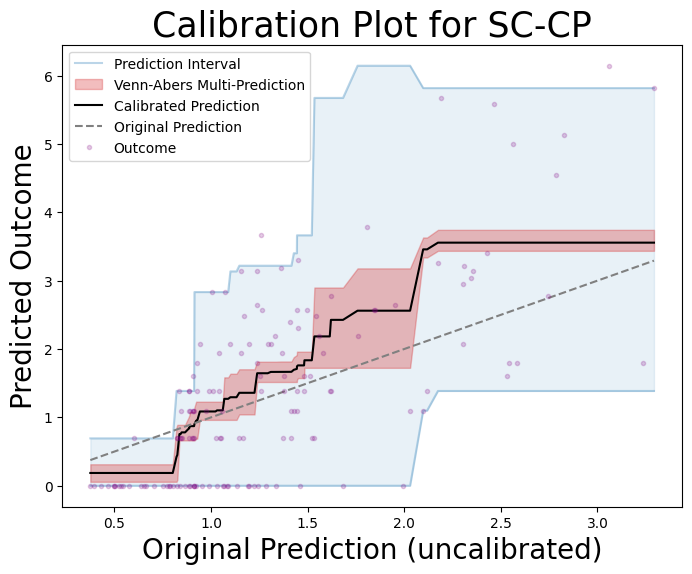

In [8]:
fig, axes = conformal_predictor.plot()
fig.savefig('data_analysis/example_outputn200.pdf')

The prediction bands and calibrated predictor output by SC-CP are piece-wise constant, jump functions. However, we can use the 'smooth' argument to obtain locally-linear kernel-smoothed predictions and bands. We note that there are no distribution-free guarantees for smoothing and doing so can hurt coverage and calibration.


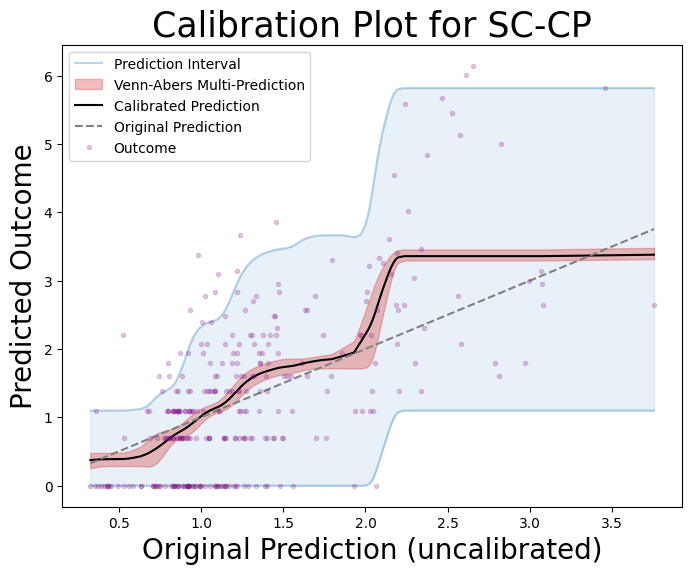

[0.9, 2.742222335786799]


In [10]:

#Calibrated point predictions derived from Venn-Abers
prediction_calibrated = conformal_predictor.predict_point(X_test, smooth = True)
# Worst and best case bounds for Venn-Abers calibrated multi-prediction
prediction_venn_abers = conformal_predictor.predict_venn_abers(X_test, smooth = True)
# Prediction interval
prediction_interval = conformal_predictor.predict_interval(X_test, smooth = True)

conformal_predictor.plot(smooth = True)

# Prints coverage and average interval width on test data
print(conformal_predictor.check_coverage(X_test, y_test, smooth = True))